In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [6]:
df = pd.read_csv('dataset_reformate.csv')
df['date'] = pd.to_datetime(df['date'])
df[['nombre_total', 'entree_mensuelle']] = df[['nombre_total', 'entree_mensuelle']].astype(int)
df

,pays,date,nombre_total,entree_mensuelle
0,Albanie,2014-02-01,1333,16
1,Allemagne,2014-02-01,306716,445
2,Andorre,2014-02-01,23,0
3,Autriche,2014-02-01,41225,-37
4,Bélarus,2014-02-01,1143,39
...,...,...,...,...
25795,Total Océanie,2024-10-01,4010,37
25796,Apatride,2024-10-01,1254,6
25797,Sans nationalité,2024-10-01,272,3
25798,Etat inconnu,2024-10-01,1089,2


In [7]:
df_grouped = df.groupby(['pays', 'date']).sum().reset_index()
df_grouped

,pays,date,nombre_total,entree_mensuelle
0,Afghanistan,2014-02-01,2437,43
1,Afghanistan,2014-03-01,2475,38
2,Afghanistan,2014-04-01,2496,21
3,Afghanistan,2014-05-01,2535,39
4,Afghanistan,2014-06-01,2567,32
...,...,...,...,...
25795,Zimbabwe,2024-06-01,251,-4
25796,Zimbabwe,2024-07-01,250,-1
25797,Zimbabwe,2024-08-01,249,-1
25798,Zimbabwe,2024-09-01,243,-6


In [8]:
fig = px.line(df_grouped, x='date', y='entree_mensuelle', color='pays', title='Nombre total de migrants par pays')
fig.show()

Epoch 1/50


c:\HES-SO\TSM-AnSeqDa\TSM-AnSeqDa\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0723 - val_loss: 0.0309
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0501 - val_loss: 0.0146
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0311 - val_loss: 0.0040
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0219 - val_loss: 0.0033
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0149 - val_loss: 0.0194
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0170 - val_loss: 0.0135
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0107 - val_loss: 0.0041
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0107 - val_loss: 0.0028
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0081 - val_loss: 0.0024
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0071 - val_loss: 0.0024
Epoch 13/50

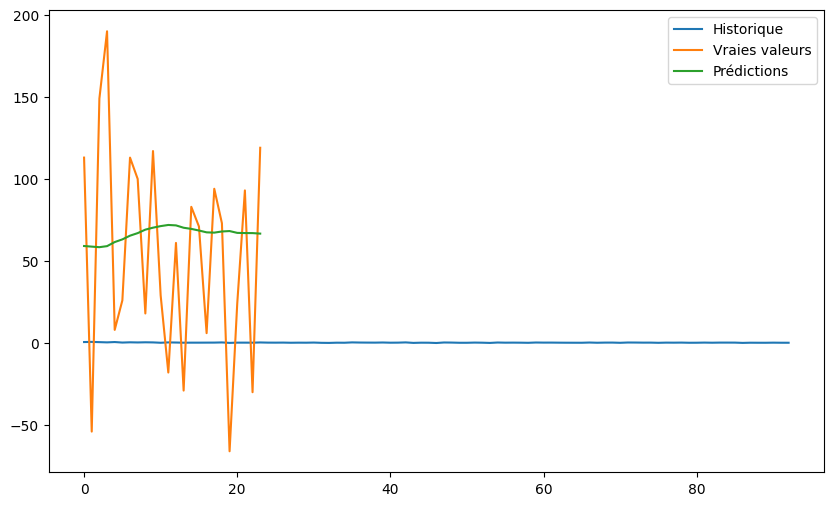

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Charger les données
data = pd.read_csv("dataset_reformate.csv")  # Remplacez par le chemin de votre fichier
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['pays', 'date'])

data = data[data['pays'] == 'Kosovo']

# Prétraitement : normalisation
scalers = {}
for column in ['nombre_total', 'entree_mensuelle']:
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[column] = scaler.fit_transform(data[[column]])
    scalers[column] = scaler

# Préparation des séquences
sequence_length = 12  # Utilisez les 12 derniers mois pour prédire le suivant
sequences = []
targets = []

countries = data['pays'].unique()
for country in countries:
    country_data = data[data['pays'] == country]
    for i in range(len(country_data) - sequence_length):
        seq = country_data.iloc[i:i+sequence_length][['nombre_total', 'entree_mensuelle']].values
        target = country_data.iloc[i+sequence_length]['entree_mensuelle']
        sequences.append(seq)
        targets.append(target)

sequences = np.array(sequences)
targets = np.array(targets)

# Division en ensembles d'entraînement et de test
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Construction du modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 2), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entraînement
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Évaluation
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Prédictions
y_pred = model.predict(X_test)

# Denormaliser les prédictions pour obtenir des valeurs réelles
y_pred = scalers['entree_mensuelle'].inverse_transform(y_pred)
y_test = scalers['entree_mensuelle'].inverse_transform(y_test.reshape(-1, 1))

# Visualisation (facultative)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Historique')
plt.plot(y_test, label='Vraies valeurs')
plt.plot(y_pred, label='Prédictions')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Charger les données
data = pd.read_csv("dataset_reformate.csv")  # Remplacez par votre fichier
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['pays', 'date'])

# Séparer données d'entraînement et de test
train_data = data[(data['date'] >= "2008-01-01") & (data['date'] <= "2022-12-31")]
test_data = data[(data['date'] >= "2023-01-01") & (data['date'] <= "2024-12-31")]

# Normalisation
scalers = {}
train_data_normalized = pd.DataFrame()
for country in train_data['pays'].unique():
    country_data = train_data[train_data['pays'] == country]
    scaler = MinMaxScaler(feature_range=(0, 1))
    country_normalized = pd.DataFrame(scaler.fit_transform(country_data[['nombre_total', 'entree_mensuelle']]),
                                      columns=['nombre_total', 'entree_mensuelle'])
    country_normalized['date'] = country_data['date'].values
    country_normalized['pays'] = country
    train_data_normalized = pd.concat([train_data_normalized, country_normalized])
    scalers[country] = scaler

# Création des séquences
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length, :])
        targets.append(data[i+sequence_length, 1])  # La deuxième colonne est `entree_mensuelle`
    return np.array(sequences), np.array(targets)

sequence_length = 12
X_train, y_train = [], []
for country in train_data_normalized['pays'].unique():
    country_data = train_data_normalized[train_data_normalized['pays'] == country]
    country_sequences, country_targets = create_sequences(country_data[['nombre_total', 'entree_mensuelle']].values, sequence_length)
    X_train.append(country_sequences)
    y_train.append(country_targets)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Construction du modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Prédictions pour 2023-2024
predictions = {}
for country in test_data['pays'].unique():
    country_test = test_data[test_data['pays'] == country]
    country_train = train_data[train_data['pays'] == country]
    full_data = pd.concat([country_train, country_test])
    
    scaler = scalers[country]
    normalized_full = scaler.transform(full_data[['nombre_total', 'entree_mensuelle']])
    
    test_start = len(country_train) - sequence_length
    inputs = normalized_full[test_start:test_start+sequence_length, :]
    pred_sequence = []
    
    for _ in range(len(country_test)):
        pred = model.predict(inputs.reshape(1, sequence_length, 2))
        pred_sequence.append(pred[0, 0])
        inputs = np.append(inputs[1:], [[inputs[-1, 0], pred[0, 0]]], axis=0)
    
    pred_sequence = scaler.inverse_transform([[0, x] for x in pred_sequence])[:, 1]
    predictions[country] = pred_sequence

# Visualisation
plt.figure(figsize=(12, 8))
for country in predictions:
    country_data = pd.concat([train_data[train_data['pays'] == country], test_data[test_data['pays'] == country]])
    dates = country_data['date']
    true_values = country_data['entree_mensuelle'].values
    plt.plot(dates, true_values, label=f'{country} - Réel', alpha=0.6)
    plt.plot(test_data[test_data['pays'] == country]['date'], predictions[country], linestyle='--', label=f'{country} - Prédit')

plt.xlabel('Date')
plt.ylabel('Entrée mensuelle')
plt.title('Prédictions LSTM par pays (2008-2024)')
plt.legend(loc='best')
plt.show()

Epoch 1/50


c:\HES-SO\TSM-AnSeqDa\TSM-AnSeqDa\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0403
Epoch 2/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0232
Epoch 3/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0220
Epoch 4/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0215
Epoch 5/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0218
Epoch 6/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0222
Epoch 7/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0215
Epoch 8/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0212
Epoch 9/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0214
Epoch 10/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0210
Epoch 11/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0210
Epoch 12/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0207
Epoch 13/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0215
Epoch 14/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0201
Epoch 15/50
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 

In [13]:
df = pd.read_csv('dataset_reformate.csv')
df['date'] = pd.to_datetime(df['date'])
df[['nombre_total', 'entree_mensuelle']] = df[['nombre_total', 'entree_mensuelle']].astype(int)
df

,pays,date,nombre_total,entree_mensuelle
0,Albanie,2014-02-01,1333,16
1,Allemagne,2014-02-01,306716,445
2,Andorre,2014-02-01,23,0
3,Autriche,2014-02-01,41225,-37
4,Bélarus,2014-02-01,1143,39
...,...,...,...,...
25795,Total Océanie,2024-10-01,4010,37
25796,Apatride,2024-10-01,1254,6
25797,Sans nationalité,2024-10-01,272,3
25798,Etat inconnu,2024-10-01,1089,2


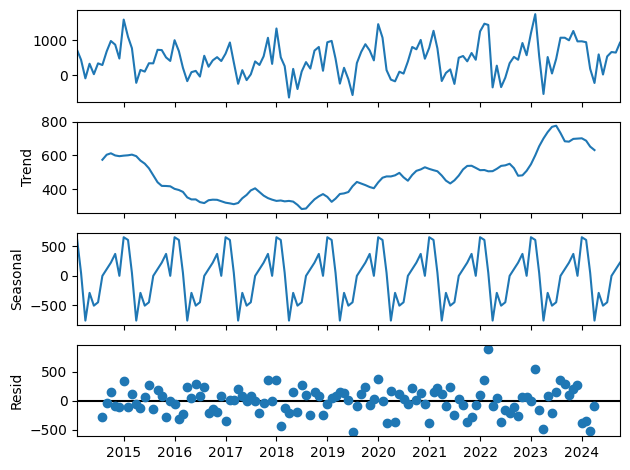

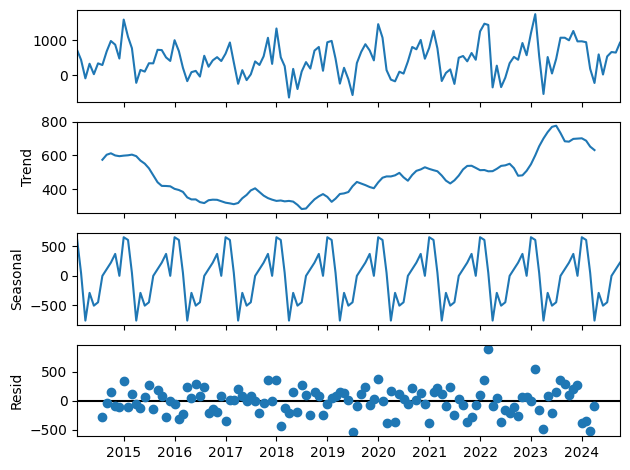

In [21]:
df_grouped = df.groupby(['pays', 'date']).sum().reset_index()

# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

df_grouped = df_grouped[df_grouped['pays'] == 'France']

df_grouped = df_grouped.set_index('date')
df_grouped = df_grouped[['entree_mensuelle']]

result = seasonal_decompose(df_grouped, model='additive', period=12)
result.plot()

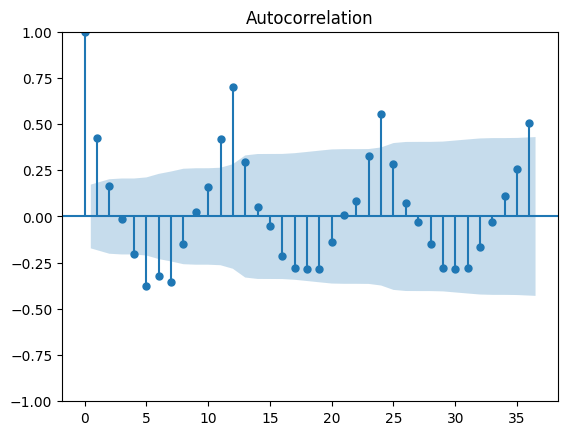

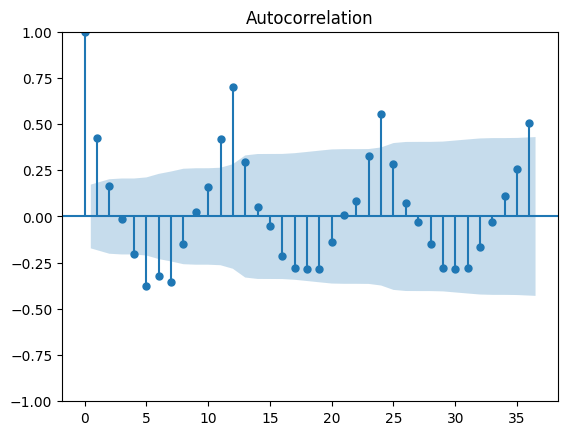

In [22]:
# Auto Correlation
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_grouped['entree_mensuelle'], lags=36)

In [29]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_grouped['entree_mensuelle'], order=(1, 1, 1), freq='M')
model_fit = model.fit()
model_fit.summary()

# Prédictions
forecast = model_fit.forecast(steps=12)
forecast

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['entree_mensuelle'], label='Données réelles')
plt.plot(forecast, label='Prédictions')
plt.legend()
plt.show()

c:\HES-SO\TSM-AnSeqDa\TSM-AnSeqDa\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



ValueError: Lengths must match to compare